<a href="https://www.kaggle.com/code/georgiosspyrou1/youtube-video-virality-predictor-eda?scriptVersionId=227870154" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🚀 Tube Virality Project  

![Python](https://img.shields.io/badge/-Python-000?&logo=Python)  

## 🎯 YouTube Trending Video Analytics API  

### **Project Purpose**  
The **Tube Virality** project aims to **collect, analyze, and model YouTube trending video data** across multiple countries using the **YouTube API**. This project goes beyond simply analyzing existing APIs; we are **building a custom API** to retrieve metadata—including view counts, likes, and descriptions—from YouTube videos and channels.

### **Key Objectives**  
- ✅ **Develop a custom API** to fetch YouTube video statistics.  
- ✅ **Collect trending videos** from various countries and store historical data.  
- ✅ **Analyze the collected data** to identify trends and patterns in virality.  
- ✅ **Build predictive models** to estimate a video's potential to go viral.

---

## 🛠️ How the Data is Collected  

The data is automatically collected using the **YouTube API** and stored in this GitHub repository:  
🔗 [Trending Video Metadata](https://github.com/gpsyrou/tube-virality/tree/main/assets/meta/trending)  

### **Collection Process**  
1. **Fetching Trending Videos**  
   - Using the YouTube API, trending videos from multiple countries are retrieved.  
   - The list of trending videos is stored and continuously updated.  

2. **Daily Statistics Updates** (Automated via **GitHub Actions**)  
   - A scheduled **GitHub Actions** workflow updates video statistics (views, likes, comments, etc.).  
   - These updates provide **historical trends** for analysis.  
   - The latest data is stored here:  
     🔗 [Video Statistics](https://github.com/gpsyrou/tube-virality/tree/main/assets/meta/video_stats)  

```mermaid
graph TD;
    A[trending.py: Fetch Trending Videos] -->|Generates daily JSON files - one per country| B[trending_db.py: Aggregate Trending Data];
    B -->|Merges all country JSONs into a unified CSV| C[video_stats.py: Extract & Fetch Video Stats];
    C -->|Creates a daily JSON file with statistics for all videos| D[video_stats_db.py: Compile Video Stats History];
    D -->|Combines all daily stats JSONs into a final dataset| E[Complete Merged Video Stats JSON];
```
---

## 🔍 Understanding Video Virality  

### **What Defines a Viral Video?**  
A video's **virality** isn't simply measured by view count—it depends on engagement, growth rate, and audience reach. Here are key factors:  
📌 **Engagement Rate** – Likes, comments, and shares relative to views.  
📌 **Subscriber Growth** – New subscribers gained after the video is posted.  
📌 **Rapid View Growth** – Views gained in the first 24-48 hours.  

For instance:  
- A YouTuber with **1M subscribers** getting **20M views** is expected.  
- A YouTuber with **10K subscribers** getting **2M views** is **extraordinary**.  

Our models will classify videos as **"success" (viral)** or **"non-success"**, based on these metrics.

---

## 📊 Dataset & Features  

Our dataset includes key **video metadata** and **engagement statistics**, such as:  

- **Video Details**: Title, description, duration, resolution  
- **Engagement Metrics**: Views, likes, comments, favorite count  
- **Channel Details**: Subscriber count, total videos, upload frequency  
- **Trending History**: How long a video remains on the trending list  
- **Country-Based Analysis**: Virality trends across different regions  

📌 **Goal:** Use these features to identify patterns and train models for virality prediction.  

---

## 🔬 Methodology  

1️⃣ **Data Collection** – Retrieve daily trending videos across countries.  
2️⃣ **Data Cleaning & Preprocessing** – Handle missing values, outliers, and standardize data.  
3️⃣ **Exploratory Analysis** – Identify key trends and patterns.  
4️⃣ **Feature Engineering** – Extract additional insights like growth rate and engagement score.  
5️⃣ **Model Development** – Train ML models for virality prediction.  
6️⃣ **Evaluation & Interpretation** – Validate predictions and refine models.  

---

## 💡 Technologies Utilized  

We've harnessed a blend of cutting-edge technologies to power the **Tube Virality** project:  

🔹 **Python 3.9** – Data processing, analysis, and ML model training.  
🔹 **SQL** – Storing structured video metadata for analysis.  

---


In [65]:
import re
import json
import logging
import requests
import warnings
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional, Union, List, Dict, Any, Tuple

In [66]:
class GitHubDataLoader:
    def __init__(self, user, repo, file_path, branch="main"):
        self.user = user
        self.repo = repo
        self.file_path = file_path
        self.branch = branch
        self.raw_url = f"https://raw.githubusercontent.com/{self.user}/{self.repo}/{self.branch}/{self.file_path}"

    def get_csv_file(self):
        response = requests.get(self.raw_url)
        response.raise_for_status()
        return response.text 

    def csv_to_dataframe(self, csv_content):
        df = pd.read_csv(StringIO(csv_content))
        return df

In [67]:
YOUTUBE_CATEGORY_MAP = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    31: "Anime/Animation",
    32: "Action/Adventure",
    33: "Classics",
    34: "Comedy (Movies)",
    35: "Documentary",
    36: "Drama",
    37: "Family",
    38: "Foreign",
    39: "Horror",
    40: "Sci-Fi/Fantasy",
    41: "Thriller",
    42: "Shorts",
    43: "Shows",
    44: "Trailers"
}

## Trending Videos Analysis

In [68]:
loader = GitHubDataLoader(user='gpsyrou', repo='tube-virality', branch='main', file_path='db/ods/trending_videos.csv')

trending_videos_content = loader.get_csv_file()

trending_videos_df = loader.csv_to_dataframe(trending_videos_content)

In [69]:
print(trending_videos_df.shape)

(8000, 15)


In [70]:
trending_videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    8000 non-null   object 
 1   trending_position     8000 non-null   int64  
 2   collection_date       8000 non-null   object 
 3   publishedAt           8000 non-null   object 
 4   country_code          8000 non-null   object 
 5   channelId             8000 non-null   object 
 6   channelTitle          8000 non-null   object 
 7   title                 8000 non-null   object 
 8   description           7353 non-null   object 
 9   categoryId            8000 non-null   int64  
 10  viewCount             7999 non-null   float64
 11  likeCount             7943 non-null   float64
 12  commentCount          7905 non-null   float64
 13  thumbnail_url         8000 non-null   object 
 14  defaultAudioLanguage  6330 non-null   object 
dtypes: float64(3), int64(

In [71]:
trending_videos_df.describe()

,trending_position,categoryId,viewCount,likeCount,commentCount
count,8000.000000,8000.000000,7.999000e+03,7.943000e+03,7905.000000
mean,25.500000,19.529125,5.696686e+06,1.934014e+05,4994.788615
std,14.431772,6.190452,1.574628e+07,5.478521e+05,17131.175636
min,1.000000,1.000000,1.117700e+04,1.070000e+02,0.000000
25%,13.000000,17.000000,2.791185e+05,9.094000e+03,452.000000
50%,25.500000,22.000000,7.751630e+05,2.607600e+04,1380.000000
75%,38.000000,24.000000,2.963887e+06,1.194120e+05,3680.000000
max,50.000000,29.000000,1.743756e+08,8.776626e+06,550226.000000


In [72]:
trending_videos_df.describe(include=["object", "bool"])

,id,collection_date,publishedAt,country_code,channelId,channelTitle,title,description,thumbnail_url,defaultAudioLanguage
count,8000,8000,8000,8000,8000,8000,8000,7353,8000,6330
unique,2658,16,2617,10,1846,1846,2689,2448,2660,49
top,JSFG-IE8n_c,2025-03-04,2025-03-07T05:00:06Z,IN,UCN9_L9lA9kqJbGANLRus_1A,JennieRubyJaneVEVO,JENNIE - like JENNIE (Official Video),Subscribe ❤️,https://i.ytimg.com/vi/JSFG-IE8n_c/hqdefault.jpg,en
freq,37,500,37,800,76,76,37,30,37,2025


In [73]:
class ODSToStageProcessor:
    """
    Processes and cleans YouTube data from ODS (raw) format to a cleaner stage format.
    """
    def __init__(self, category_map: dict = {}):
        self.category_map = category_map
        
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def pt_to_minutes(self, pt_string: str):
        """Convert ISO 8601 duration format (PT format) to minutes"""
        if not isinstance(pt_string, str) or not pt_string.startswith("PT"):
            return 0.0
        
        match = re.match(r"^PT(\d+H)?(\d+M)?(\d+S)?$", pt_string)
        if match:
            hours = int(match.group(1).replace('H', '') if match.group(1) else 0)
            minutes = int(match.group(2).replace('M', '') if match.group(2) else 0)
            seconds = int(match.group(3).replace('S', '') if match.group(3) else 0)
            return hours * 60 + minutes + (seconds / 60)
        return 0.0

    def trending_ods_to_stage(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Cleans and preprocesses a YouTube trending videos DataFrame for analysis.
        """
        self.logger.info("Started processing trending ODS data.")
        df = df.copy()
        
        try:
            df.rename(columns={'id': 'video_id'}, inplace=True)
            self.logger.info("Renamed columns successfully.")
        except Exception as e:
            self.logger.error(f"Error renaming columns: {e}")

        try:
            df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce").dt.strftime('%Y-%m-%d %H:%M:%S')
            self.logger.info("'publishedAt' column converted successfully.")
        except Exception as e:
            self.logger.error(f"Error converting 'publishedAt' column: {e}")
        
        for col in ["viewCount", "likeCount", "commentCount"]:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
                self.logger.info(f"Converted {col} to integers.")
            except Exception as e:
                self.logger.error(f"Error converting {col}: {e}")

        try:
            df["categoryId"] = pd.to_numeric(df["categoryId"], errors="coerce").fillna(0).astype("Int64")
            self.logger.info("'categoryId' column converted successfully.")
        except Exception as e:
            self.logger.error(f"Error converting 'categoryId': {e}")
        
        df["category_descr"] = df["categoryId"].map(self.category_map).fillna("Unknown")
        self.logger.info("Category mapping completed.")
        
        if "defaultAudioLanguage" in df.columns:
            df["defaultAudioLanguage"] = df["defaultAudioLanguage"].astype(str).str.upper()
            self.logger.info("Converted 'defaultAudioLanguage' to uppercase.")
        
        column_order = [
            "video_id", 
            "collection_date", 
            "position", 
            "publishedAt", 
            "title", 
            "channelTitle", 
            "categoryId", 
            "category_descr",
            "viewCount", 
            "likeCount", 
            "commentCount", 
            "defaultAudioLanguage"
        ]
        
        df = df[[col for col in column_order if col in df.columns] + [col for col in df.columns if col not in column_order]]
        
        self.logger.info("Completed processing of trending ODS data.")
        return df
    

    def video_stats_ods_to_stage(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Cleans and preprocesses a YouTube video statistics DataFrame for analysis.
        """
        self.logger.info("Started processing video stats ODS data.")
        df = df.copy()
        
        try:
            df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce").dt.strftime('%Y-%m-%d %H:%M:%S')
            self.logger.info("'published_at' column converted successfully.")
        except Exception as e:
            self.logger.error(f"Error converting 'published_at' column: {e}")

        for col in ["caption", "licensed_content", "embeddable", "public_stats_viewable"]:
            try:
                df[col] = df[col].astype(bool)
                self.logger.info(f"Converted {col} to boolean.")
            except Exception as e:
                self.logger.error(f"Error converting {col}: {e}")
        
        for col in ["view_count", "like_count", "comment_count"]:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
                self.logger.info(f"Converted {col} to integers.")
            except Exception as e:
                self.logger.error(f"Error converting {col}: {e}")
        
        if "tags" in df.columns:
            try:
                df["tags"] = df["tags"].apply(lambda x: ", ".join(x) if isinstance(x, list) else str(x))
                self.logger.info("Converted 'tags' column to string.")
            except Exception as e:
                self.logger.error(f"Error processing 'tags' column: {e}")

        if "collection_day" in df.columns:
            df['collection_day'] = pd.to_datetime(df['collection_day'])
        
        if "duration" in df.columns:
            try:
                df["duration_in_minutes"] = df["duration"].apply(self.pt_to_minutes).round(3)
                self.logger.info("Transformed 'duration' to minutes.")
            except Exception as e:
                self.logger.error(f"Error transforming 'duration' column: {e}")

        column_order = [
            "video_id", 
            "channel_id", 
            "title", 
            "description", 
            "published_at", 
            "tags", 
            "view_count", 
            "like_count", 
            "comment_count", 
            "duration", 
            "duration_in_minutes", 
            "dimension", 
            "definition", 
            "caption", 
            "licensed_content", 
            "projection", 
            "privacy_status", 
            "license", 
            "embeddable", 
            "public_stats_viewable", 
            "topic_categories", 
            "collection_day", 
            "country_code"
        ]
        
        df = df[[col for col in column_order if col in df.columns] + [col for col in df.columns if col not in column_order]]
        
        self.logger.info("Completed processing of video stats ODS data.")
        return df


In [74]:
ots_processor = ODSToStageProcessor(category_map=YOUTUBE_CATEGORY_MAP)

In [75]:
trending_df_stage = ots_processor.trending_ods_to_stage(df=trending_videos_df)

In [76]:
print(f'There are {trending_df_stage.video_id.nunique()} unique videos collected from trending')

There are 2658 unique videos collected from trending


In [77]:
trending_df_stage.groupby('video_id').agg(
    min_date_at_trending=('collection_date', 'min'),
    max_date_at_trending=('collection_date', 'max'),
    min_trending_position=('trending_position', 'min'),
    max_trending_position=('trending_position', 'max')
)

,min_date_at_trending,max_date_at_trending,min_trending_position,max_trending_position
video_id,,,,
--MGIIuNZy8,2025-02-24,2025-02-25,32,45
-0bQdILhBjU,2025-03-14,2025-03-14,48,48
-0dKgdKWJP0,2025-03-01,2025-03-02,15,33
-3Bme6nVN-4,2025-03-08,2025-03-08,33,33
-5LbOXvq6CQ,2025-03-11,2025-03-14,2,48
...,...,...,...,...
zplovcrtZao,2025-03-15,2025-03-15,26,26
zq-8qPk4vDw,2025-03-10,2025-03-12,18,42
zqJhEYWEGjw,2025-03-08,2025-03-10,31,38


## Videos Statistics Analysis

In [78]:
loader = GitHubDataLoader(user="gpsyrou", repo="tube-virality", branch='main', file_path="db/ods/merged_video_stats.csv")

video_stats_content = loader.get_csv_file()

video_statistics_df = loader.csv_to_dataframe(video_stats_content)

In [79]:
video_stats_df_stage = ots_processor.video_stats_ods_to_stage(df=video_statistics_df)

In [80]:
video_stats_df_stage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29989 entries, 0 to 29988
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   video_id               29989 non-null  object        
 1   channel_id             29989 non-null  object        
 2   title                  29989 non-null  object        
 3   description            28144 non-null  object        
 4   published_at           29989 non-null  object        
 5   tags                   29989 non-null  object        
 6   view_count             29989 non-null  int64         
 7   like_count             29989 non-null  int64         
 8   comment_count          29989 non-null  int64         
 9   duration               29989 non-null  object        
 10  duration_in_minutes    29989 non-null  float64       
 11  dimension              29989 non-null  object        
 12  definition             29989 non-null  object        
 13  c

In [81]:
video_stats_df_stage.describe(include=['object', 'bool'])

,video_id,channel_id,title,description,published_at,tags,duration,dimension,definition,caption,licensed_content,projection,privacy_status,license,embeddable,public_stats_viewable,topic_categories,country_code
count,29989,29989,29989,28144,29989,29989,29989,29989,29989,29989,29989,29989,29989,29989,29989,29989,29989,29989
unique,2657,1848,2748,2577,2614,1922,1555,1,2,2,2,1,2,2,2,2,244,10
top,Ej3b18FJwL0,UCvrhwpnp2DHYQ1CbXby9ypQ,Sunn Mere Dil Last EP 40 [Eng Sub] Presented b...,Folllow me on Instagram- https://www.instagra...,2025-02-20 23:00:06,nan,PT40S,2d,hd,False,True,rectangular,public,youtube,True,True,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,IN
freq,21,239,21,134,105,6691,237,29989,29974,25877,27493,29989,29985,29854,29304,26439,3799,4826


In [82]:
print(f'There are {video_stats_df_stage.video_id.nunique()} unique videos collected from video statistics pipeline')

There are 2657 unique videos collected from video statistics pipeline


In [83]:
print("The trending videos that we can not collect video statistics for are:")
[x for x in list(trending_df_stage['video_id']) if x not in list(video_stats_df_stage['video_id'])]

The trending videos that we can not collect video statistics for are:


['Df_iFpKEIRU']

In [84]:
video_stats_df_stage.groupby(['video_id', 'published_at', 'duration_in_minutes']).agg(
    num_stats_collection_days=('collection_day', 'size'),
    min_stats_collection_day=('collection_day', 'min'),
    max_stats_collection_day=('collection_day', 'max'),
    max_num_views=('view_count', 'max'),
    max_num_likes=('like_count', 'max'),
    max_num_comments=('comment_count', 'max')
)

,,,num_stats_collection_days,min_stats_collection_day,max_stats_collection_day,max_num_views,max_num_likes,max_num_comments
video_id,published_at,duration_in_minutes,,,,,,
--MGIIuNZy8,2025-02-22 15:00:00,22.967,19,2025-02-25,2025-03-15,3409889,54589,3072
-0bQdILhBjU,2025-03-13 11:31:01,18.317,2,2025-03-14,2025-03-15,30903,4982,702
-0dKgdKWJP0,2025-02-28 12:30:07,41.733,15,2025-03-01,2025-03-15,1433305,44269,4153
-3Bme6nVN-4,2025-03-05 17:00:00,29.733,3,2025-03-08,2025-03-10,128784,1895,298
-5LbOXvq6CQ,2025-03-10 16:08:23,19.367,5,2025-03-11,2025-03-15,423285,28704,744
...,...,...,...,...,...,...,...,...
zplovcrtZao,2025-03-13 23:51:54,7.450,1,2025-03-15,2025-03-15,153748,1591,591
zq-8qPk4vDw,2025-03-08 23:16:42,11.267,6,2025-03-10,2025-03-15,195574,8557,2106
zqJhEYWEGjw,2025-03-08 05:30:01,16.167,8,2025-03-08,2025-03-15,544922,3275,132


In [85]:
video_stats_df_stage.columns

Index(['video_id', 'channel_id', 'title', 'description', 'published_at',
       'tags', 'view_count', 'like_count', 'comment_count', 'duration',
       'duration_in_minutes', 'dimension', 'definition', 'caption',
       'licensed_content', 'projection', 'privacy_status', 'license',
       'embeddable', 'public_stats_viewable', 'topic_categories',
       'collection_day', 'country_code'],
      dtype='object')

In [86]:
class VideoMetricsVisualizer:
    """
    A class for visualizing metrics from YouTube video statistics.
    """
    
    def __init__(self, df: pd.DataFrame):
        """
        Initialize the VideoMetricsVisualizer with a dataframe of video statistics.
        
        Parameters:
        -----------
        df : pd.DataFrame
            The dataframe containing video statistics with the required schema
        """
        self.df = df
        
        # Ensure collection_day is datetime
        if 'collection_day' in self.df.columns and not pd.api.types.is_datetime64_any_dtype(self.df['collection_day']):
            self.df['collection_day'] = pd.to_datetime(self.df['collection_day'], errors='coerce')
    
    def plot_video_metrics_over_time(self, video_id: str) -> matplotlib.figure.Figure:
        """
        Plot the view count, like count, and comment count for a specific video_id across collection days.
        """
        # Filter the dataframe for the specific video_id
        video_df = self.df[self.df['video_id'] == video_id].copy()
        
        # Check if data exists for the video_id
        if video_df.empty:
            raise ValueError(f"No data found for video_id: {video_id}")
        
        # Sort by collection_day to ensure chronological order
        video_df = video_df.sort_values('collection_day')
        
        # Create a figure with 3 subplots side by side
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, message=".*missing from current font.*")
            
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # View Count
            axes[0].plot(video_df['collection_day'], video_df['view_count'], marker='o', linestyle='-', color='blue')
            axes[0].set_title('View Count Over Time')
            axes[0].set_xlabel('Collection Date')
            axes[0].set_ylabel('View Count')
            axes[0].grid(True, alpha=0.3)
            axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[0].tick_params(axis='x', rotation=45)
            
            # Likes Count
            axes[1].plot(video_df['collection_day'], video_df['like_count'], marker='o', linestyle='-', color='green')
            axes[1].set_title('Like Count Over Time')
            axes[1].set_xlabel('Collection Date')
            axes[1].set_ylabel('Like Count')
            axes[1].grid(True, alpha=0.3)
            axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[1].tick_params(axis='x', rotation=45)
            
            # Comment Count
            axes[2].plot(video_df['collection_day'], video_df['comment_count'], marker='o', linestyle='-', color='red')
            axes[2].set_title('Comment Count Over Time')
            axes[2].set_xlabel('Collection Date')
            axes[2].set_ylabel('Comment Count')
            axes[2].grid(True, alpha=0.3)
            axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[2].tick_params(axis='x', rotation=45)
            
            plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle
            
            return fig

In [87]:
video_stats_df_stage.video_id.unique()

array(['CpzMAiDwfHc', 'kshqQSqIW9M', 'QdUhS8BNjWo', ..., 'fbSUVzxNiLM',
       'hQaq_A7tbIY', '9LvQ1EKYhvo'], dtype=object)

In [88]:
video_stats_visualizer = VideoMetricsVisualizer(video_stats_df_stage)

In [89]:
video_id = 'CpzMAiDwfHc'

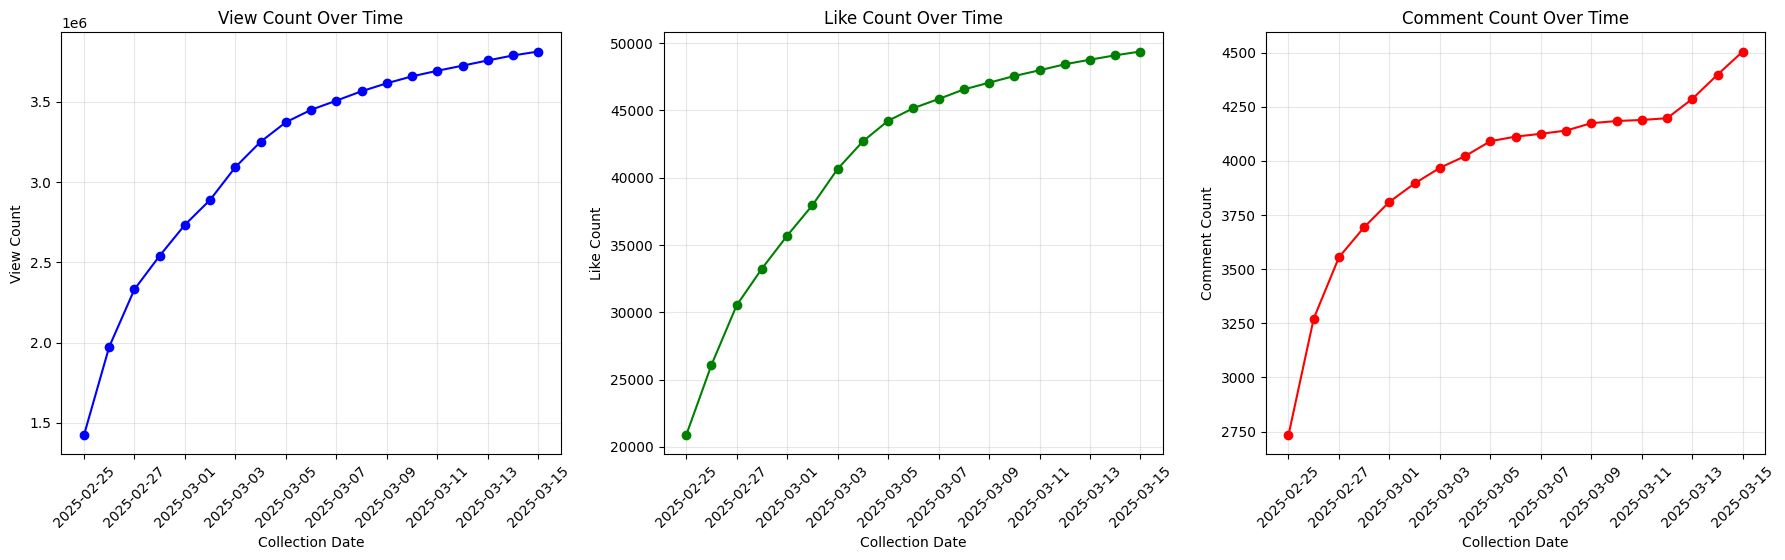

In [90]:
video_stats_visualizer.plot_video_metrics_over_time(video_id).show()